In [1]:
#Ref 李弘毅 教授 ML課程HW1


# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [3]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [4]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            # nn.Linear(input_dim,1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [5]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1], test_data[:, -1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data[:, :-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [5,6] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test

In [6]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    # optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 30,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-3,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [65]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('./makeNTU_new.csv').values, pd.read_csv('./sunny_single.csv', header=None).values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])
# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")
# print(type(test_data))
# print(test_data[-1])
# Select features
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test, y_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (42240, 8) 
valid_data size: (10559, 8) 
test_data size: (660, 8)
number of features: 7


In [ ]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/300]: 100%|██████████| 165/165 [00:01<00:00, 90.35it/s, loss=0.161]


Epoch [1/300]: Train loss: 0.8433, Valid loss: 0.1508
Saving model with loss 0.151...


Epoch [2/300]: 100%|██████████| 165/165 [00:01<00:00, 101.88it/s, loss=0.0589]


Epoch [2/300]: Train loss: 0.0893, Valid loss: 0.0621
Saving model with loss 0.062...


Epoch [3/300]: 100%|██████████| 165/165 [00:01<00:00, 93.15it/s, loss=0.0341]


Epoch [3/300]: Train loss: 0.0534, Valid loss: 0.0377
Saving model with loss 0.038...


Epoch [4/300]: 100%|██████████| 165/165 [00:01<00:00, 92.59it/s, loss=0.021]


Epoch [4/300]: Train loss: 0.0296, Valid loss: 0.0236
Saving model with loss 0.024...


Epoch [5/300]: 100%|██████████| 165/165 [00:01<00:00, 82.57it/s, loss=0.0234]


Epoch [5/300]: Train loss: 0.0226, Valid loss: 0.0208
Saving model with loss 0.021...


Epoch [6/300]: 100%|██████████| 165/165 [00:01<00:00, 92.73it/s, loss=0.0226]


Epoch [6/300]: Train loss: 0.0212, Valid loss: 0.0201
Saving model with loss 0.020...


Epoch [7/300]: 100%|██████████| 165/165 [00:02<00:00, 73.26it/s, loss=0.0184]


Epoch [7/300]: Train loss: 0.0197, Valid loss: 0.0184
Saving model with loss 0.018...


Epoch [8/300]: 100%|██████████| 165/165 [00:02<00:00, 65.88it/s, loss=0.0172]


Epoch [8/300]: Train loss: 0.0184, Valid loss: 0.0175
Saving model with loss 0.018...


Epoch [9/300]: 100%|██████████| 165/165 [00:02<00:00, 73.43it/s, loss=0.0177]


Epoch [9/300]: Train loss: 0.0177, Valid loss: 0.0160
Saving model with loss 0.016...


Epoch [10/300]: 100%|██████████| 165/165 [00:02<00:00, 73.27it/s, loss=0.015]


Epoch [10/300]: Train loss: 0.0169, Valid loss: 0.0158
Saving model with loss 0.016...


Epoch [11/300]: 100%|██████████| 165/165 [00:03<00:00, 51.48it/s, loss=0.0152]


Epoch [11/300]: Train loss: 0.0156, Valid loss: 0.0155
Saving model with loss 0.015...


Epoch [12/300]: 100%|██████████| 165/165 [00:02<00:00, 73.37it/s, loss=0.0169]


Epoch [12/300]: Train loss: 0.0150, Valid loss: 0.0143
Saving model with loss 0.014...


Epoch [13/300]: 100%|██████████| 165/165 [00:02<00:00, 69.01it/s, loss=0.014]


Epoch [13/300]: Train loss: 0.0149, Valid loss: 0.0158


Epoch [14/300]: 100%|██████████| 165/165 [00:02<00:00, 70.96it/s, loss=0.0162]


Epoch [14/300]: Train loss: 0.0154, Valid loss: 0.0151


Epoch [15/300]: 100%|██████████| 165/165 [00:02<00:00, 67.58it/s, loss=0.0139]


Epoch [15/300]: Train loss: 0.0150, Valid loss: 0.0153


Epoch [16/300]: 100%|██████████| 165/165 [00:02<00:00, 60.51it/s, loss=0.0144]


Epoch [16/300]: Train loss: 0.0148, Valid loss: 0.0141
Saving model with loss 0.014...


Epoch [17/300]:  95%|█████████▍| 156/165 [00:04<00:00, 35.65it/s, loss=0.0158]

100%|██████████| 42/42 [00:00<00:00, 79.12it/s]


anomaly detection: 0.022634719196893645


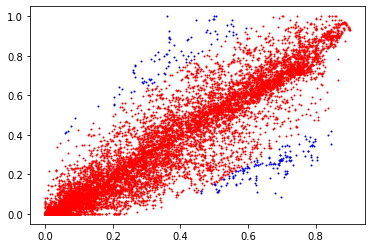

In [63]:
model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
model.eval()
results = []
normal_x = []
normal_y = []
abnormal_x = []
abnormal_y = []



for x,y in tqdm(valid_loader):
  x = x.to(device)
  # print(x)
  pred = model(x)
  pred = torch.clamp(pred, min=0, max=1)
  dif = abs(pred-y)
  for i in range(len(dif)):
    
    if dif[i]>0.345:
      abnormal_x.append(pred[i].detach().numpy())
      abnormal_y.append(y[i])
    else:
      normal_x.append(pred[i].detach().numpy())
      normal_y.append(y[i])


print("anomaly detection:", len(abnormal_x)/((len(abnormal_x)+len(normal_x)))
)

import matplotlib.pyplot as plt

# print(normal_x)
# print(normal_y)

plt.scatter(normal_x, normal_y, c='red', s=1)
plt.scatter(abnormal_x, abnormal_y, c='blue', s=1)

100%|██████████| 3/3 [00:00<00:00, 44.33it/s]

anomaly detection: 0.0


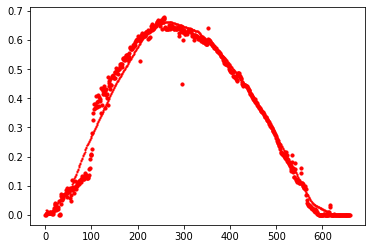

In [73]:
model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
model.eval()
results = []
normal_x = []
normal_y = []
normal_y2 = []
abnormal_x = []
abnormal_y = []
abnormal_y2 = []


cnt = 0
for x,y in tqdm(test_loader):
  x = x.to(device)
  # print(x)
  pred = model(x)
  pred = torch.clamp(pred, min=0, max=1)
  dif = abs(pred-y)
  for i in range(len(dif)):
    if dif[i]>0.345:
      abnormal_x.append(cnt)
      abnormal_y2.append(pred[i].detach().numpy())
      abnormal_y.append(y[i])
    else:
      normal_x.append(cnt)
      normal_y2.append(pred[i].detach().numpy())
      normal_y.append(y[i])
    cnt += 1

print("anomaly detection:", len(abnormal_x)/((len(abnormal_x)+len(normal_x)))
)

import matplotlib.pyplot as plt

# print(normal_x)
# print(normal_y)

plt.scatter(normal_x, normal_y, c='red', s=10)
plt.scatter(abnormal_x, abnormal_y, c='blue', s=10)

plt.scatter(normal_x, normal_y2, c='red', s=1)
plt.scatter(abnormal_x, abnormal_y2, c='blue', s=1)